# Simulation Settings

In [1]:
import matplotlib.pyplot as plt
from cideMOD import (
    CellParser,
    Problem,
    Trigger, 
    VerbosityLevel,
    get_model_options
)

plt.rc('font', family='serif')


In [2]:
model = 'P2D'
case = "Xu_2015"
data_path = f"../../data/data_{case}"
cell_data = "params.json"

model_options = get_model_options(
    model=model,
    solve_thermal=True,
    verbose=VerbosityLevel.DETAILED_PROGRESS_INFO,
    clean_on_exit=False,
    raise_errors_on_exit=False)


In [3]:
cell = CellParser(cell_data, data_path, model_options)


Negative electrode capacity: 0.101727
Positive electrode capacity: 0.169504
Cell capacity: 0.101727


In [4]:
C_rates = [0.5, 1, 2]  # Positive == discharge in this notebook

T_0 = 273 + 20  # temperature in Kelvin

v_min = 2.1  # Cut-off voltage

timesteps = [20, 10, 5]  # int, float or List[int,float] of length len(C_rates)


# Experimental

In [5]:
import os
import numpy as np

results = dict()
results["Experimental"] = dict()
experimental_data_path = os.path.join(data_path, 'reference_data')
experimental_files = os.listdir(experimental_data_path)
for C_rate in C_rates:
    files = [file for file in experimental_files if f"{C_rate:.3g}C" in file]
    if files:
        results["Experimental"][f"{C_rate:.3g}C"] = dict()
    for file in files:
        if file.startswith('T_'):
            var = 'temperature'
            results["Experimental"][f"{C_rate:.3g}C"][var] = {
                'unit': 'ºC', 'source': 'file', 'value': file}
        elif file.startswith('V_'):
            var = 'voltage'
            results["Experimental"][f"{C_rate:.3g}C"][var] = {
                'unit': 'V', 'source': 'file', 'value': file}
        else:
            raise ValueError(f"Unrecognized results file '{file}'")
            
        # Load data
        path = os.path.join(experimental_data_path, file)
        assert os.path.exists(path), f"Path to experimental data '{path}' doesn't exists"
        arr = np.genfromtxt(path, delimiter=' ')
        results["Experimental"][f"{C_rate:.3g}C"][var]['array'] = arr


# P2D

In [6]:
assert model_options.model == 'P2D'
results["P2D"] = dict()
for i, C_rate in enumerate(C_rates):
    save_path = f"results/{case}_{model_options.model}_{C_rate:.3g}C"
    if i==0:
        problem = Problem(cell, model_options)
        problem.update_save_path(save_path)
        problem.set_cell_state(SoC=1, T_ini=273 + 20, T_ext=273 + 20)
        problem.setup()
    else:
        problem.reset(save_path=save_path)
    I_app = -C_rate * cell.ref_capacity
    t_f = 3600 /abs(C_rate)*1.25
    min_step = timesteps if not isinstance(timesteps, list) else timesteps[i]

    status = problem.solve(min_step=min_step, i_app=I_app, t_f=t_f, 
                           store_delay=-1, adaptive=False, triggers=[Trigger(v_min, "v")])

    results["P2D"][f"{C_rate:.3g}C"] = {key:np.array(problem.get_global_variable(key), dtype=float)
                                        for key in problem._WH._requested_outputs['globals']}


Building mesh for P2D problem with 5 components and 150 nodes
Finished mesh construction
Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Xu_2015_P2D_0.5C
Building problem setup
- Building FEM function spaces - Done
- Building cell parameters:
    Setting up 'cell' parameters
    Setting up 'cell.electrolyte' parameters
    Setting up 'cell.anode' parameters
    Setting up 'cell.anode.am0' parameters
    Setting up 'cell.cathode' parameters
    Setting up 'cell.cathode.am0' parameters
    Setting up 'cell.separator' parameters
    Setting up 'cell.negativeCC' parameters
    Setting up 'cell.positiveCC' parameters
- Building cell parameters - Done
- Initializing state - Done       
- Build variational formulation - Done 
- Building solvers - Done           
Initializing solution
Solving ...
Voltage is 2.1 V at 1h 58min 24s                     

Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Xu_2015_P2D_1C
Reseti

# P4D

In [14]:
model_options.model = 'P4D'
read_results = False
results["P4D"] = dict()
for i, C_rate in enumerate(C_rates):
    save_path = f"results/results_{case}_{model_options.model}_{C_rate:.3g}C"
    if read_results and os.path.exists(os.path.join(save_path, "voltage.txt")):
        results["P4D"][f"{C_rate:.3g}C"] = dict()
        for key in ['voltage', 'capacity', 'temperature']:
            path = os.path.join(save_path, f"{key}.txt")
            if os.path.exists(path):
                arr = np.loadtxt(path)
                results["P4D"][f"{C_rate:.3g}C"][key] = arr[:,1]
                if 'time' not in results["P4D"][f"{C_rate:.3g}C"]:
                    results["P4D"][f"{C_rate:.3g}C"]['time'] = arr[:,0]
        continue
    
    problem.reset(save_path=save_path)
    I_app = -C_rate * cell.ref_capacity
    t_f = 3600 / abs(C_rate)*1.25
    min_step = timesteps if not isinstance(timesteps, list) else timesteps[i]

    status = problem.solve(min_step=min_step, i_app=I_app, t_f=t_f, 
                           store_delay=10, adaptive=True, triggers=[Trigger(v_min, "v")])

    results["P4D"][f"{C_rate:.3g}C"] = {
        key: np.array(problem.get_global_variable(key), 
                      dtype=float) for key in problem._WH._requested_outputs['globals']
        }


Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Xu_2015_P4D_0.5C
Reseting the problem - Done
Initializing solution
Solving ...
Voltage is 2.1 V at 1h 58min 24s                     

Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Xu_2015_P4D_1C
Reseting the problem - Done
Initializing solution
Solving ...
Voltage is 2.1 V at 58min 20s                        

Saving results to /home/fenicsx/shared/cideMOD/examples/scripts_paper/results/results_Xu_2015_P4D_2C
Reseting the problem - Done
Initializing solution
Solving ...
Voltage is 2.1 V at 28min 30s                        



# Compare results

In [15]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=False) # True if you have a LaTeX interpreter installed
plt.rc('font', family='serif')

plot_dict = {
    "0.5C" : {
        "Experimental": {'fnc': 'scatter', 'marker': 'o', 'c': '#76B64A', 's': 5, 'label' : 'Experimental 0.5C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#FFBF00', 'label' : 'cideMOD P2D 0.5C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#F69200', 'label' : 'cideMOD P4D 0.5C', 'zorder': 30}
    },
    "1C" : {
        "Experimental": {'fnc': 'scatter', 'marker': 's', 'c': 'k', 's': 5, 'label' : 'Experimental 1C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#FF0000', 'label' : 'cideMOD P2D 1C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#D31FAC', 'label' : 'cideMOD P4D 1C', 'zorder': 30},
        # "Xu": {'fnc': 'plot', 'linestyle' : '--', 'c': '#D31FAC', 'label' : 'Xu sim. 0.5C', 'zorder': 15}
    },
    "2C" : {
        "Experimental": {'fnc': 'scatter', 'marker': '^', 'c': '#3D6CC2', 's': 5, 'label' : 'Experimental 2C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#C51919', 'label' : 'cideMOD P2D 2C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': '#CF580F', 'label' : 'cideMOD P4D 2C', 'zorder': 30}
    },
    "default": {
        "Experimental": {'fnc': 'scatter', 'marker': 'o', 'c': None, 's': 5, 'label' : 'Experimental {C_rate:3g}C', 'zorder': 10},
        "P2D": {'fnc': 'plot', 'linestyle' : '-', 'c': None, 'label' : 'cideMOD P2D {C_rate:3g}C', 'zorder': 20},
        "P4D": {'fnc': 'plot', 'linestyle' : '-', 'c': None, 'label' : 'cideMOD P4D {C_rate:3g}C', 'zorder': 30}
    }
}
table_dict_voltage={}
table_dict_temperature={}


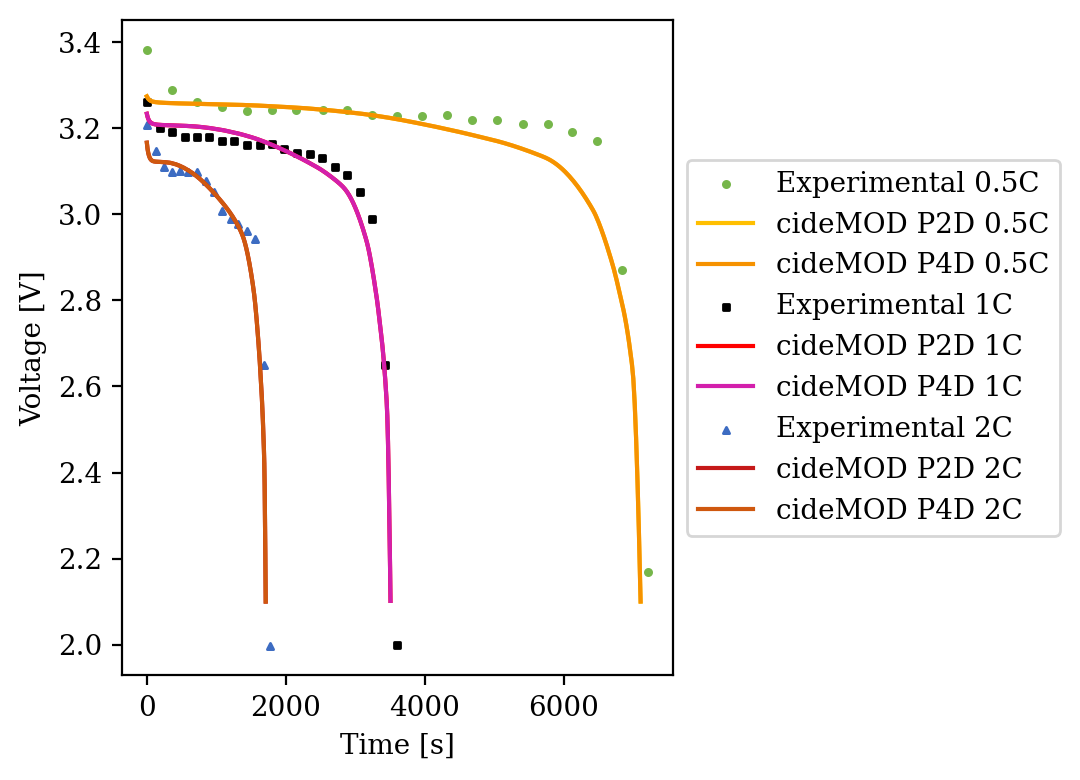

In [16]:
# Plot voltage results over time
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
for C_rate in C_rates:
    table_dict_voltage[f"{C_rate:.3g}C"]={}
    plot_config = plot_dict.get(f"{C_rate:.3g}C",  plot_dict["default"])
    for dataset, data_dict in plot_config.items():
        if dataset not in results or f"{C_rate:.3g}C" not in results[dataset]:
            continue
        if dataset in ['Experimental']:
            arr = results[dataset][f"{C_rate:.3g}C"]['voltage']['array']
            X, Y = arr[:,0], arr[:,1]
        else:
            X = results[dataset][f"{C_rate:.3g}C"]['time']
            Y = results[dataset][f"{C_rate:.3g}C"]['voltage']

        kwargs = {k:v for k,v in data_dict.items() if k not in [ 'fnc', 'label']}
        label = data_dict.get('label', f'{dataset}_{C_rate:3g}C').format(C_rate=C_rate)
        if 'fnc' not in data_dict or data_dict['fnc'] == 'plot':
            ax.plot(X, Y, label = label, **kwargs)
        elif data_dict['fnc'] == 'scatter':
            ax.scatter(X, Y, label = label, **kwargs)
        else:
            getattr(ax, data_dict['fnc'])(X, Y, label = label, **kwargs)
        table_dict_voltage[f"{C_rate:.3g}C"][dataset]=[X,Y]
ax.set_xlabel("Time [s]")
ax.set_ylabel("Voltage [V]")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

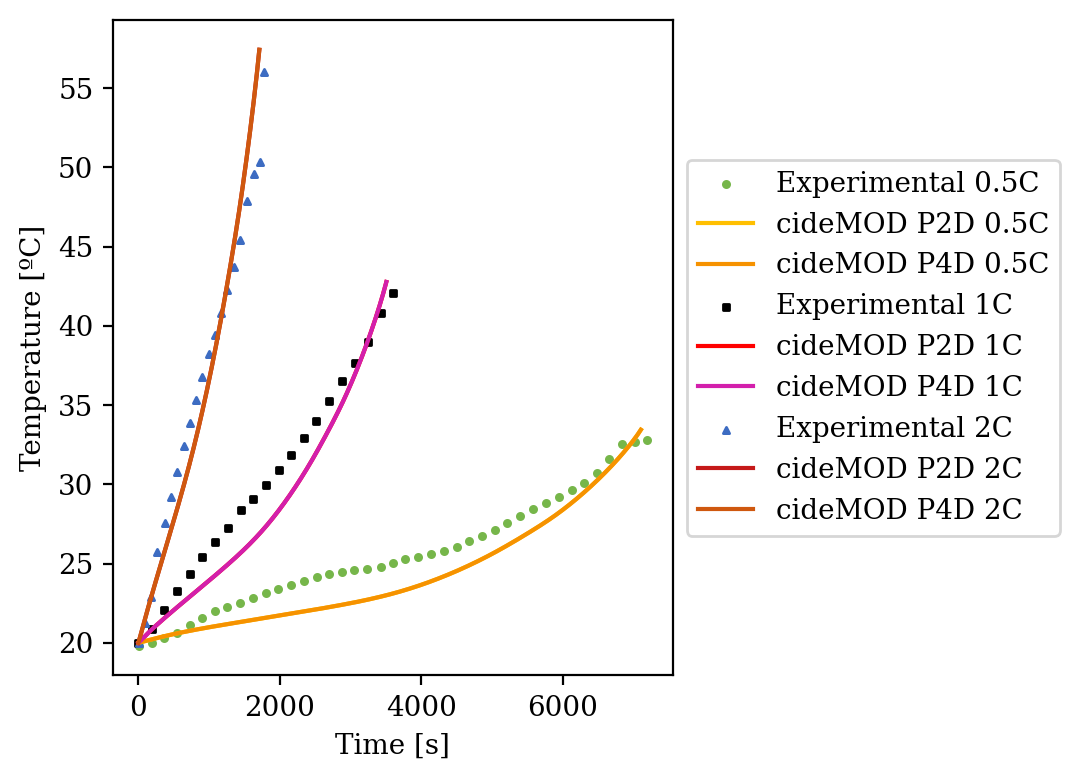

In [17]:
# Plot temperature results over time
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
for C_rate in C_rates:
    plot_config = plot_dict.get(f"{C_rate:.3g}C",  plot_dict["default"])
    table_dict_temperature[f"{C_rate:.3g}C"]={}
    for dataset, data_dict in plot_config.items():
        if dataset not in results or f"{C_rate:.3g}C" not in results[dataset]:
            continue
        if dataset in ['Experimental']:
            arr = results[dataset][f"{C_rate:.3g}C"]['temperature']['array']
            X, Y = arr[:,0], arr[:,1] # TODO: Check results[dataset][f"{C_rate:.3g}C"]['temperature']['unit']
        else:
            X = results[dataset][f"{C_rate:.3g}C"]['time']
            Y = np.array(results[dataset][f"{C_rate:.3g}C"]['T_max'], dtype = float) - 273 # ºC

        kwargs = {k:v for k,v in data_dict.items() if k not in [ 'fnc', 'label']}
        label = data_dict.get('label', f'{dataset}_{C_rate:3g}C').format(C_rate=C_rate)
        if 'fnc' not in data_dict or data_dict['fnc'] == 'plot':
            ax.plot(X, Y, label = label, **kwargs)
        elif data_dict['fnc'] == 'scatter':
            ax.scatter(X, Y, label = label, **kwargs)
        else:
            getattr(ax, data_dict['fnc'])(X, Y, label = label, **kwargs)
        table_dict_temperature[f"{C_rate:.3g}C"][dataset]=[X,Y]
        
ax.set_xlabel("Time [s]")
ax.set_ylabel("Temperature [ºC]")
# ax.legend(loc="best") 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [11]:
from scipy.interpolate import interp1d
from tabulate import tabulate

table_list_v = []
table_list_t = []

for key, item in table_dict_voltage.items():
    real_x, real_y = table_dict_voltage[key]["Experimental"]
    results_x_y = [table_dict_voltage[key][k] for k in item.keys() if k != "Experimental"]
    results_tag = [k for k in item.keys() if k != "Experimental"]
    real = interp1d(real_x, real_y, bounds_error=False)
    int_results = [interp1d(res[0], res[1], bounds_error=False) for res in results_x_y]

    time = np.linspace(
        max([real_x[0]]+[res[0][0] for res in results_x_y]), 
        min([real_x[-1]]+[res[0][-1] for res in results_x_y]), 
        100) 

    # plot the RMSE over time
    for result, tag in zip(int_results, results_tag):
        rmse = np.sqrt(np.sum((real(time)-result(time))**2)/len(time))*1e3
        peak = np.abs(real(time)-result(time)).max()*1e3
        name = f"{tag} {key}"
        table_list_v.append([name, rmse, peak])

for key, item in table_dict_temperature.items():
    real_x, real_y = table_dict_temperature[key]["Experimental"]
    results_x_y = [table_dict_temperature[key][k] for k in item.keys() if k != "Experimental"]
    results_tag = [k for k in item.keys() if k != "Experimental"]
    real = interp1d(real_x, real_y, bounds_error=False)
    int_results = [interp1d(res[0], res[1], bounds_error=False) for res in results_x_y]

    time = np.linspace(
        max([real_x[0]]+[res[0][0] for res in results_x_y]), 
        min([real_x[-1]]+[res[0][-1] for res in results_x_y]), 
        100) 

    # plot the RMSE over time
    for result, tag in zip(int_results, results_tag):
        rmse = np.sqrt(np.sum((real(time)-result(time))**2)/len(time))
        peak = np.abs(real(time)-result(time)).max()
        name = f"{tag} {key}"
        table_list_t.append([name, rmse, peak])

print(tabulate(table_list_v, headers = ['', "RMSE (mV)", "Peak error (mV)"], floatfmt=".0f"))
print(tabulate(table_list_t, headers = ['', "RMSE (ºC)", "Peak error (ºC)"], floatfmt=".2f"))

            RMSE (mV)    Peak error (mV)
--------  -----------  -----------------
P2D 0.5C           27                109
P4D 0.5C           27                109
P2D 1C             40                242
P4D 1C             40                242
P2D 2C             20                 58
P4D 2C             20                 58
            RMSE (ºC)    Peak error (ºC)
--------  -----------  -----------------
P2D 0.5C         1.49               2.09
P4D 0.5C         1.49               2.09
P2D 1C           1.82               2.70
P4D 1C           1.82               2.70
P2D 2C           2.33               7.12
P4D 2C           2.33               7.12
